In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
results_df = pd.read_csv("results/batch_run_results.csv")

In [42]:
#select the columns
results_df_select = results_df[['Year', 'RunId','seed', 'threshold_concern', 'positive_feedback', 'Impact count']]
#group by year and runid at the same time



results_df_agg = results_df_select.groupby(['Year', 'RunId', 'seed', 'threshold_concern', 'positive_feedback']).agg({'Impact count': 'mean'}).reset_index()
results_df_agg.head(100)

,Year,RunId,seed,threshold_concern,positive_feedback,Impact count
0,2020,0,0,0.3821,1.0,0.372598
1,2020,1,0,0.3821,0.5,0.372598
2,2020,2,0,0.3500,1.0,0.372598
3,2020,3,0,0.3500,0.5,0.372598
4,2020,4,0,0.3000,1.0,0.372598
...,...,...,...,...,...,...
95,2023,5,0,0.3000,0.5,0.332267
96,2023,6,1,0.3821,1.0,0.381652
97,2023,7,1,0.3821,0.5,0.381652
98,2023,8,1,0.3500,1.0,0.315855


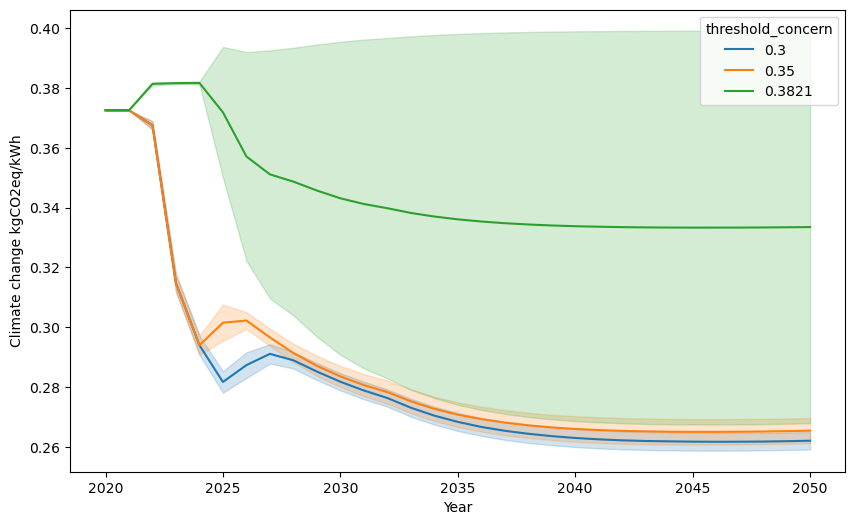

In [73]:
# Filter the dataframe for threshold_concern = 0.3821
filtered_df = results_df_agg[results_df_agg["positive_feedback"] == 1]


# Create a lineplot with impact versus year with different colors for different thresholds and error based on the different seeds
plt.figure(figsize=(10, 6))
g = sns.lineplot(
    data=filtered_df,
    # data=results_df_agg,
    x="Year",
    y="Impact count",
    # hue="positive_feedback",
    hue="threshold_concern",
    palette="tab10",
    errorbar="sd"
)
g.set(ylabel="Climate change kgCO2eq/kWh", xlabel="Year")
plt.show()

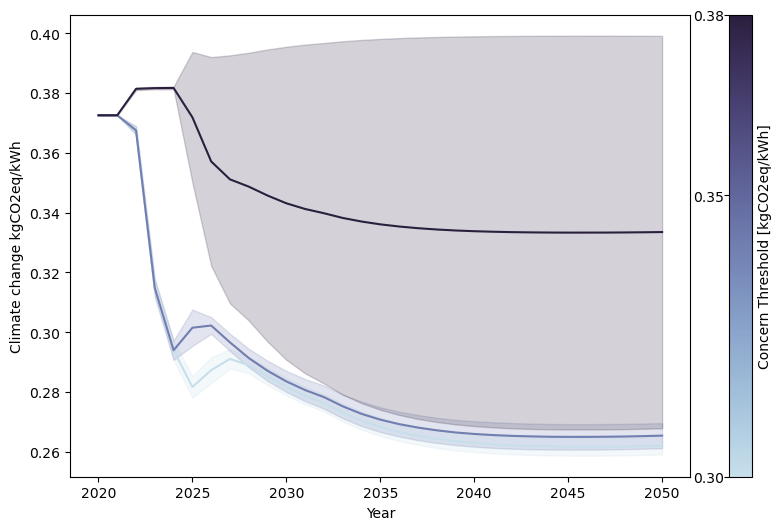

In [70]:
import numpy as np  
# Define the color palette
blue = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
number_of_runs = 3
linecolors = [blue(i / (number_of_runs - 1)) for i in range(number_of_runs)]

filtered_df = results_df_agg[results_df_agg["positive_feedback"] == 1]

# Create a lineplot with impact versus year with different colors for different thresholds and error based on the different seeds
plt.figure(figsize=(10, 6))
g = sns.lineplot(
    data=filtered_df,
    x="Year",
    y="Impact count",
    hue="threshold_concern",
    palette=linecolors,
    errorbar="sd",
    legend=False
)
g.set(ylabel="Climate change kgCO2eq/kWh", xlabel="Year")

# INSTEAD OF LEGEND FOR HUE USE COLOR BAR
# Create a color bar and show only actual values in the color bar

norm = plt.Normalize(filtered_df['threshold_concern'].min(), filtered_df['threshold_concern'].max())
sm = plt.cm.ScalarMappable(cmap=blue, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=g.axes)
cbar.set_label("Concern Threshold [kgCO2eq/kWh]")

# Set the ticks to the unique values of 'threshold_concern'
unique_thresholds = np.sort(filtered_df['threshold_concern'].unique())
cbar.set_ticks(unique_thresholds)
cbar.set_ticklabels([f'{val:.2f}' for val in unique_thresholds])
# show thiks on other side
cbar.ax.yaxis.set_ticks_position('left')
#add space for the labels
cbar.ax.yaxis.set_label_position('right')
# add space for the bar
cbar.ax.yaxis.set_tick_params(pad=0)

plt.show()